# MOORDS: MOORing Design and Simulation

This notebook shows the procedure to:
1. Load a mooring element database
1. Design a set of moorings
1. Generate mooring diagrams
1. Check serial numbers
1. Generate summary tables in .pdf
1. Export the design to CSV (for MATLAB import)
1. Simulate the mooring in a flow (single instance and time series)

## Load Modules
The package `moords` contains the design and simulation tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import moords

# configure pandas to show full table
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# specify compile directory
output_dir = "output/example"

## Element Database

This database contains the properties of various mooring components. Specifically, the element lengths are essential for the mooring design, while additional properties (such as buoyancy, width, and others) are utilized for simulating the mooring system. This database can be constructed by:

1. Building a `pd.DataFrame` by, for instance, combining a list of dictonaries containing the element properties
2. Importing a `.csv` file to be converted to a `pd.DataFrame` using the `morods.load_database_from_csv` function

Each element contains the following properties:
- name: element name
- type: element type (e.g., arcels, anchors, rigging, chains, cms, floats, miscs, wires)
- buoyancy_kg: buoyancy in [kg] with positive buoyancy being upwards
- length_m: element length in [m]
- width_m: element width in [m] (= 0 for a sphere)
- diameter_m: element diameter in [m] (= 0 if not a sphere)
- drag: drag coefficient
- material: material index used for modulus of elasticity for stretching wires and chains under tension. (index: material, 1: Steel, 2: Nylon, 3: Dacron, 4: Polyprop, 5: Polyethy, 6: Kevlar, 7: Aluminum, 8: Dyneema)
- comment: additional user comment

In the provided examples, mooring M1 is constructed using the first approach, while mooring M2 is constructed using the second approach.  

In [2]:
columns = [
    "name",
    "type",
    "buoyancy_kg",
    "length_m",
    "width_m",
    "diameter_m",
    "drag",
    "material",
    "comment",
]
rows = [
    ["3 Railway Wheels", "anchors", -1350.0, 0.55, 1.0, 0.0, 1.3, 1, ""],
    ["3/8 wire rope", "wires", -0.33, 1.0, 0.009, 0.0, 1.3, 1, ""],
    ["Zn Anode (UWA)", "miscs", -0.05, 0.2, 0.025, 0.0, 1.3, 5, ""],
    ["41in ORE", "floats", 433.0, 1.04, 0.0, 1.04, 0.65, 1, ""],
    ["FLNTUSB (UWA)", "miscs", -0.25, 0.31, 0.11, 0.0, 1.3, 5, ""],
    ["SBE39 T (UWA)", "miscs", -0.25, 0.31, 0.11, 0.0, 1.3, 5, ""],
]
df_database = pd.DataFrame(rows, columns=columns).set_index("name")
df_database.head()  # show the first rows of the database

,type,buoyancy_kg,length_m,width_m,diameter_m,drag,material,comment
name,,,,,,,,
3 Railway Wheels,anchors,-1350.00,0.55,1.000,0.00,1.30,1,
3/8 wire rope,wires,-0.33,1.00,0.009,0.00,1.30,1,
Zn Anode (UWA),miscs,-0.05,0.20,0.025,0.00,1.30,5,
41in ORE,floats,433.00,1.04,0.000,1.04,0.65,1,
FLNTUSB (UWA),miscs,-0.25,0.31,0.110,0.00,1.30,5,


## Design

Moorings are designed by first initializing the `moords.Mooring` object (locally imported from the `moorsys` package). A mooring is constructed sequentially using in-line elements, starting from the bottom. In-line elements can be added using the `Mooring.add_inline` function. These elements can either be a fixed-length object (e.g., a float or ADCP), or a line (e.g., a chain or rope) of a certain length. The length of the line can be specified by adding the `line_length` argument to `Mooring.add_inline`.

Adding clamp-on elements: clamp-on elements can be added in two ways:
1. Directly by defining the height along an in-line. Use the function `Mooring.add_clampon_along_inline` to attach a clamp-on to an in-line element. Note that the clamp-on will be attached to the previous in-line element.
1. Indirectly by defining the height along the entire mooring. Use the function `Mooring.add_clampon_by_height` to attach a clamp-on to the in-line element at the specified height. Note that the clamp-on can only be attached to in-line elements that are already part of the mooring.

Passive clamp-on elements: a clamp-on element can be set to passive in terms of its weight and/or drag. This can be done using the `passive_weight` and `passive_drag` arguments, respectively, in combination with the functions `Mooring.add_clampon_along_inline` and `Mooring.add_clampon_by_height`. For example, a clamp-on element hidden in a buoy can have its drag component disregarded by setting it as passive.

Section labeling: in-line elements can be labeled using the `section` argument in `Mooring.add_inline`. All clamp-on elements attached to this in-line element will then be included in this section. These sections will be summarized in the generated back-deck documents.

Check total buoyancy: the buoyancy of the mooring can be checked using the function `Mooring.check_total_buoyancy`. This function verifies whether there is sufficient positive buoyancy throughout the mooring to keep all elements upright when at rest. Additionally, it checks if the anchor is heavy enough to remain submerged in the resting position. If either condition fails, the function will generate a warning.

Inspect design: The constructed mooring design can be inspected using `pandas` by compiling dataframes for the respective elements:
- In-line elements: Use `Mooring.make_df_inline`
- Clamp-on elements: Use `Mooring.make_df_clampon`
- All elements: Use `Mooring.make_df_combined`

Additionally, the mooring design can be visualized using the `Mooring.plot_design` function.


### Example: Mooring M1

In [3]:
# Start building mooring
mooring_1 = moords.Mooring(df_database, name="M1")

# In-line elements
mooring_1.add_inline("3 Railway Wheels")
mooring_1.add_inline("3/8 wire rope", line_length=50, section="A")
mooring_1.add_clampon_along_inline(
    "Zn Anode (UWA)", height_along_inline=4
)  # attach clamp-on to latest in-line: 3/8 wire rope
mooring_1.add_inline("41in ORE")

# Add clamp-on elements by height (can be done after adding all in-line elements)
mooring_1.add_clampon_by_height("FLNTUSB (UWA)", serial="2927", height=20)
mooring_1.add_clampon_by_height("SBE39 T (UWA)", serial="3921", height=30)

# Check the buoyancy of the mooring at the end
mooring_1.check_total_buoyancy()

Buoyancy check succesful


In [4]:
# View the mooring design usign the dataframes:
# mooring_1.make_df_inline().fillna('') # in-line only
# mooring_1.make_df_clampon().fillna('') # clamp-on only
mooring_1.make_df_combined().fillna("").head()  # clamp-on + in-line

,type,name,serial,bottom_height,height,length,section,bool_line,buoyancy,width,diameter,drag,material,comment,top_height,bool_clampon,total_buoyancy,num_inline,id,height_along_inline,clamped_to_name,clamped_to_serial,bool_fit,inline_bottom,inline_top,passive_weight,passive_drag,mooring
0,anchors,3 Railway Wheels,,0.0,,0.55,,False,-1350.00,1.000,0.0,1.3,1,,0.55,False,-1350.0,1,0,,,,,,,,,M1
1,wires,3/8 wire rope,,0.55,,50.00,A,True,-16.50,0.009,0.0,1.3,1,,50.55,False,-17.05,2,1,,,,,,,,,M1
2,miscs,Zn Anode (UWA),,,4.55,0.20,A,False,-0.05,0.025,0.0,1.3,5,,,True,,2,2,4.0,3/8 wire rope,,True,0.55,50.55,False,False,M1
3,miscs,FLNTUSB (UWA),2927,,20.0,0.31,A,False,-0.25,0.110,0.0,1.3,5,,,True,,2,4,19.45,3/8 wire rope,,True,0.55,50.55,False,False,M1
4,miscs,SBE39 T (UWA),3921,,30.0,0.31,A,False,-0.25,0.110,0.0,1.3,5,,,True,,2,5,29.45,3/8 wire rope,,True,0.55,50.55,False,False,M1


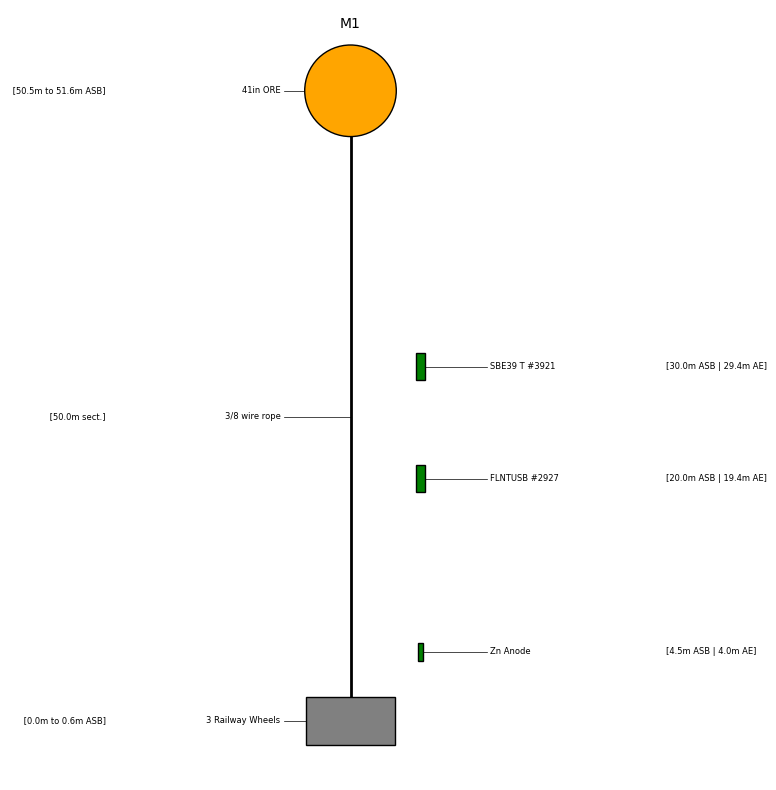

In [5]:
# Plot mooring
fig_1, ax = mooring_1.plot_design(
    label_rigging=True, drop_strings=["(UWA)"], line_ratio_plot=0.8
)
plt.show()

### Example mooring M2

Buoyancy check succesful


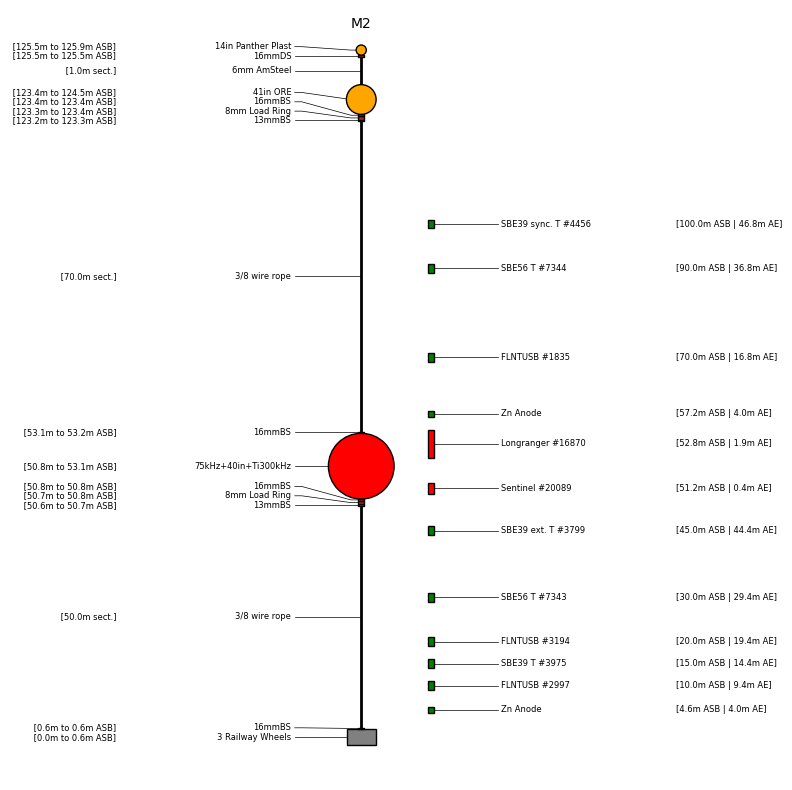

In [6]:
# Start building mooring
path_mooring_database = "data/mooring_elements/mooring_elements_data.csv"
df_database = moords.load_database_from_csv(path_mooring_database)
mooring_2 = moords.Mooring(df_database, name="M2")

# In-line elements
mooring_2.add_inline("3 Railway Wheels")
mooring_2.add_inline("16mmBS")
mooring_2.add_inline("3/8 wire rope", line_length=50, section="A")
mooring_2.add_clampon_along_inline("Zn Anode (UWA)", height_along_inline=4)
mooring_2.add_inline("13mmBS")
mooring_2.add_inline("8mm Load Ring")
mooring_2.add_inline("16mmBS")
mooring_2.add_inline("75kHz+40in+Ti300kHz (UWA)")
mooring_2.add_clampon_along_inline(
    "Sentinel",
    serial="20089",
    height_along_inline=0.37,
    passive_weight=True,
    passive_drag=True,
)
mooring_2.add_clampon_along_inline(
    "Longranger",
    serial="16870",
    height_along_inline=1.93,
    passive_weight=True,
    passive_drag=True,
)
mooring_2.add_inline("16mmBS")
mooring_2.add_inline("3/8 wire rope", line_length=70, section="B")
mooring_2.add_clampon_along_inline("Zn Anode (UWA)", height_along_inline=4)
mooring_2.add_inline("13mmBS")
mooring_2.add_inline("8mm Load Ring")
mooring_2.add_inline("16mmBS")
mooring_2.add_inline("41in ORE")
mooring_2.add_inline("6mm AmSteel", line_length=1)
mooring_2.add_inline("16mmDS")
mooring_2.add_inline("14in Panther Plast (UWA)")

# Add clamp-on elements
mooring_2.add_clampon_by_height("FLNTUSB (UWA)", serial="2997", height=10)
mooring_2.add_clampon_by_height("SBE39 T (UWA)", serial="3975", height=15)
mooring_2.add_clampon_by_height("FLNTUSB (UWA)", serial="3194", height=20)
mooring_2.add_clampon_by_height("SBE56 T (UWA)", serial="7343", height=30)
mooring_2.add_clampon_by_height("SBE39 ext. T (UWA)", serial="3799", height=45)
mooring_2.add_clampon_by_height("FLNTUSB (UWA)", serial="1835", height=70)
mooring_2.add_clampon_by_height("SBE56 T (UWA)", serial="7344", height=90)
mooring_2.add_clampon_by_height("SBE39 sync. T (UWA)", serial="4456", height=100)
mooring_2.check_total_buoyancy()

# Plot mooring
fig_2, ax = mooring_2.plot_design(
    label_rigging=True, drop_strings=["(UWA)"], line_ratio_plot=0.8
)
plt.show()

## Overview

Overview tools for the design tables and serial number checks are provided by the `moords.Overview` object. This object is initialized with a list of designed mooring objects \[`moords.Mooring`\]. An overview dataframe containing all the specified mooring designs can be accessed using `Overview.df_combined_moorings`.

In [7]:
# Make combined dataframe of selected moorings
overview = moords.Overview([mooring_1, mooring_2])
overview.df_combined_moorings.fillna("").head()

,type,name,serial,bottom_height,height,length,section,bool_line,buoyancy,width,diameter,drag,material,comment,top_height,bool_clampon,total_buoyancy,num_inline,id,height_along_inline,clamped_to_name,clamped_to_serial,bool_fit,inline_bottom,inline_top,passive_weight,passive_drag,mooring
0,anchors,3 Railway Wheels,,0.0,,0.55,,False,-1350.00,1.000,0.0,1.3,1,,0.55,False,-1350.0,1,0,,,,,,,,,M1
1,wires,3/8 wire rope,,0.55,,50.00,A,True,-16.50,0.009,0.0,1.3,1,,50.55,False,-17.05,2,1,,,,,,,,,M1
2,miscs,Zn Anode (UWA),,,4.55,0.20,A,False,-0.05,0.025,0.0,1.3,5,,,True,,2,2,4.0,3/8 wire rope,,True,0.55,50.55,False,False,M1
3,miscs,FLNTUSB (UWA),2927,,20.0,0.31,A,False,-0.25,0.110,0.0,1.3,5,,,True,,2,4,19.45,3/8 wire rope,,True,0.55,50.55,False,False,M1
4,miscs,SBE39 T (UWA),3921,,30.0,0.31,A,False,-0.25,0.110,0.0,1.3,5,,,True,,2,5,29.45,3/8 wire rope,,True,0.55,50.55,False,False,M1


### Print Tables

Generate a summary in `.pdf` format that can be used as back-deck documents for the mooring deployment. This overview can be customized using the `Overview.generate_overview_pdf` function. The summary is created using **LaTeX**, which is then converted into a `.pdf` using `pdflatex`. 

If the `pdflatex` conversion fails, the generated `.tex` file can be used with any other PDF-to-LaTeX conversion tool, such as [Overleaf](https://www.overleaf.com).


In [8]:
# Generate overview pdf
overview.generate_overview_pdf(
    file_path=f"{output_dir}/print/example_tables.pdf",
    header=r"V1, \today",
    replacements=[("_", r"\_"), ("(UWA)", ""), ("(passive)", "")],
)

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./output/example/print/example_tables.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/tools/tabularx.sty
(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty))
(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/fancyhdr/fancyhdr.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend

### Print Design

Convert the mooring design figures into a `.pdf` document using the `moords.generate_design_pdf` function. Simply supply the figures as a list to the function.

In [9]:
moords.generate_design_pdf(
    file_path=f"{output_dir}/print/example_design.pdf", list_fig=[fig_1, fig_2]
)

### Check Serial Numbers

Check serial numbers across all specified moorings:
- Duplicated serial numbers: use `print_duplicated_serial`
- Missing serial numbers: use `Overview.df_missing_serial`

This functionality can be extended to compare against any imported list of serial numbers.


In [10]:
# Check for duplicated serial numbers
overview.print_duplicated_serial()

DUPLICATED SERIAL NUMBERS
 no duplicates


In [11]:
# Overview of missing serial numbers
overview.df_missing_serial.fillna("").head()

,type,name,serial,bottom_height,height,length,section,bool_line,buoyancy,width,diameter,drag,material,comment,top_height,bool_clampon,total_buoyancy,num_inline,id,height_along_inline,clamped_to_name,clamped_to_serial,bool_fit,inline_bottom,inline_top,passive_weight,passive_drag,mooring
0,anchors,3 Railway Wheels,,0.0,,0.55,,False,-1350.00,1.000,0.00,1.30,1,,0.55,False,-1350.0,1,0,,,,,,,,,M1
1,wires,3/8 wire rope,,0.55,,50.00,A,True,-16.50,0.009,0.00,1.30,1,,50.55,False,-17.05,2,1,,,,,,,,,M1
2,miscs,Zn Anode (UWA),,,4.55,0.20,A,False,-0.05,0.025,0.00,1.30,5,,,True,,2,2,4.0,3/8 wire rope,,True,0.55,50.55,False,False,M1
5,floats,41in ORE,,50.55,,1.04,,False,433.00,0.000,1.04,0.65,1,,51.59,False,433.0,3,3,,,,,,,,,M1
6,anchors,3 Railway Wheels,,0.0,,0.55,,False,-1350.00,1.000,0.00,1.30,1,,0.55,False,-1350.0,1,0,,,,,,,,,M2


### Export

The designed moorings can be exported as `.csv` files, which can then be imported into MATLAB for detailed plotting. For further instructions, refer to the `matlab_plot/run_plot_code.m` file.

In [12]:
# Export moorings (to be imported in Matlab for detailed plotting)
for mooring in [mooring_1, mooring_2]:
    mooring.export_csv(f"{output_dir}/export/{mooring.name}.csv")

## Simulation

The mooring can be simulated for either a single time step or a time series. In the case of a time series, the flow profile varies as a function of both depth ($z$) and time ($t$). The flow profile is defined by the velocity components ($U$, $V$, $W$) and the density ($ρ$).

The simulation algorithm is based on the **Mooring Design & Dynamics MATLAB package** by Richard K. Dewey ([MoorDyn](https://web.uvic.ca/~rdewey/mooring/moordyn.php)), which has been translated into Python. Note that this Python version is designed exclusively for submerged moorings and does not yet support surface moorings. 

To simulate the mooring, the lines and chains are divided into shorter segments through interpolation. The model iteratively calculates drag, buoyancy, line tensions and line stretching to determine the equilibrium position. 

The simulation results are presented as datasets and visualizations, focusing on:
- Displacements in the $X$-$Y$ plane
- Vertical pulldown ($dZ$)
- Angle with the vertical ($ψ$)
- Tensions throughout the in-line elements
- Weight under the anchor

Note that the vertical pulldown is calculated by taking the difference between the mooring in the specified flow profile and the mooring at rest, with both configurations accounting for the stretching of the lines.


### Single Instance

A mooring can be simulated for a single instance in time using the `moords.SimulateInstance` object. The object is initiated using a `moords.Mooring` object and an `xarray` dataset of the vertical flow profile. This flow profile can be constructed by the user or imported. The simulation is runned using the `SimulateInstance.run` function. Once the simulation is complete, the results can be analyzed using the following methods:
- `SimulateInstance.plot_instance`: generates an overview plot of the mooring
- `SimulateInstance.ds_sim_instance`: provides a summary xarray dataset per element

Total Tension on Anchor = 491.6 kg
Vertical load = 491.6 kg
Horizontal load = 0.0 kg
Weight under anchor = -858.4 kg  (negative is down)


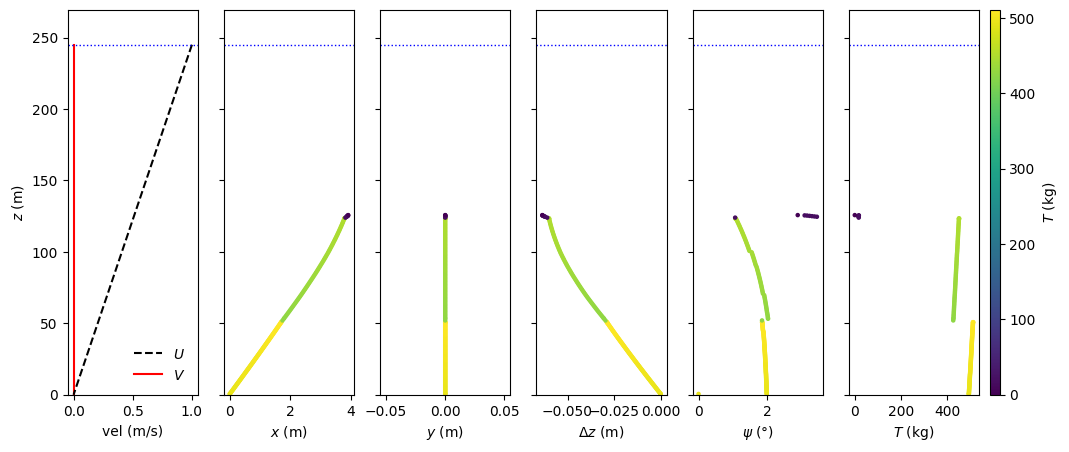

In [13]:
# Construct flow profile
bottom_depth = 245
n_z = 100
z = np.linspace(bottom_depth, 0, n_z)
ds_flow_instance = xr.Dataset(
    {
        "U": (["z"], z / bottom_depth),
        "V": (["z"], np.zeros(n_z)),
        "W": (["z"], np.zeros(n_z)),
        "rho": (["z"], 1025 * np.ones(n_z)),
        "bottom_depth": bottom_depth,
    },
    coords={
        "z": z,
    },
)

instance = moords.SimulateInstance(mooring_2, ds_flow_instance)
instance.run()
fig, ax = instance.plot_instance()
plt.show()

In [14]:
# Element summary (including clampons and inlines)
instance.ds_sim_instance

<xarray.Dataset> Size: 3kB
Dimensions:              (id: 28)
Coordinates:
  * id                   (id) int64 224B 0 1 2 3 4 5 6 ... 21 22 23 24 25 26 27
    type                 (id) object 224B 'anchors' 'rigging' ... 'miscs'
    name                 (id) object 224B '3 Railway Wheels' ... 'SBE39 sync....
    serial               (id) object 224B None None None ... '7344' '4456'
    bottom_height        (id) float64 224B 0.0 0.55 0.61 nan ... nan nan nan nan
    height               (id) float64 224B nan nan nan 4.61 ... 70.0 90.0 100.0
Data variables:
    bool_clampon         (id) bool 28B False False False True ... True True True
    X                    (id) float64 224B 0.0 0.001044 0.859 ... 2.99 3.27
    Y                    (id) float64 224B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Z                    (id) float64 224B 0.55 0.58 25.61 ... 70.0 90.0 100.0
    psi                  (id) float64 224B 0.0 1.996 1.943 ... 1.92 1.695 1.554
    tension_top          (id) float64 224B 491.6 492.3 509.9 nan ... nan nan nan
    dZ                   (id) float64 224B 0.0 -1.818e-05 ... -0.05006 -0.05396
    tension_bottom       (id) float64 224B 0.0 491.6 492.3 nan ... nan nan nan
    weight_under_anchor  float64 8B -858.4

### Time Series

A mooring can be simulated for a time series using the `moords.SimulateSeries` object. This object is initialized with a `moords.Mooring` object and an `xarray` dataset representing the time series (as a function of height and time). The flow profile can either be constructed by the user or imported, and it can be viewed using the `SimulateSeries.plot_flow_series` function. 

The simulation is run using the `SimulateSeries.run` function. Once the simulation is complete, the results can be analyzed using the following methods:
- `SimulateSeries.plot_instance`: Generates an overview plot of the mooring
- `SimulateSeries.ds_sim_instance`: Provides a physical summary xarray dataset per element
- `SimulateSeries.df_sim_series_summary`: Provides a statistical summary xarray dataset per element
- `SimulateSeries.plot_anchor_stats_series`: Generates a plot of anchor load as a function of time
- `SimulateSeries.plot_simulated_item_series`: Generates a plot of item properties as a function of time

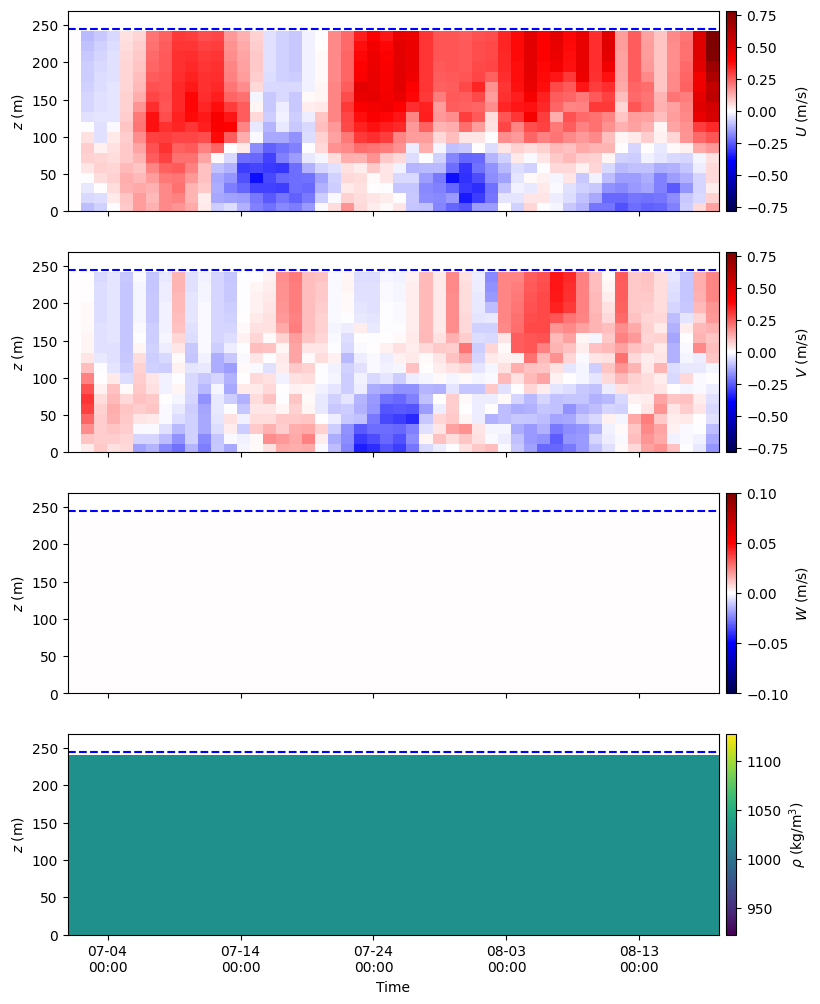

In [15]:
# Load flow series
ds_flow_series = xr.open_dataset("data/flow_series/flow_series_S245.nc")
ds_flow_series = ds_flow_series.isel(
    time=slice(0, 24 * 50, 24)
)  # only simulate every 4th step
series = moords.SimulateSeries(mooring, ds_flow_series)
fig, ax = series.plot_flow_series()
plt.show()

In [16]:
# Simulate mooring in flow series
series.run()

Progress: 50/50

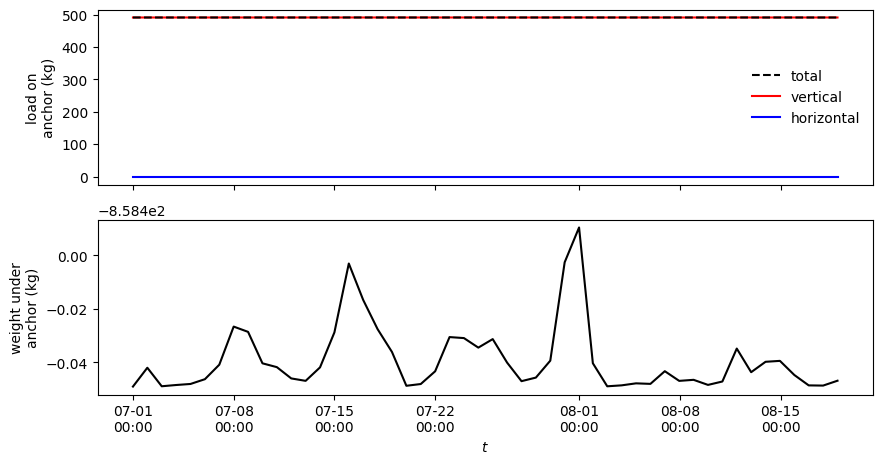

In [17]:
fig, ax = series.plot_anchor_stats_series()
plt.show()

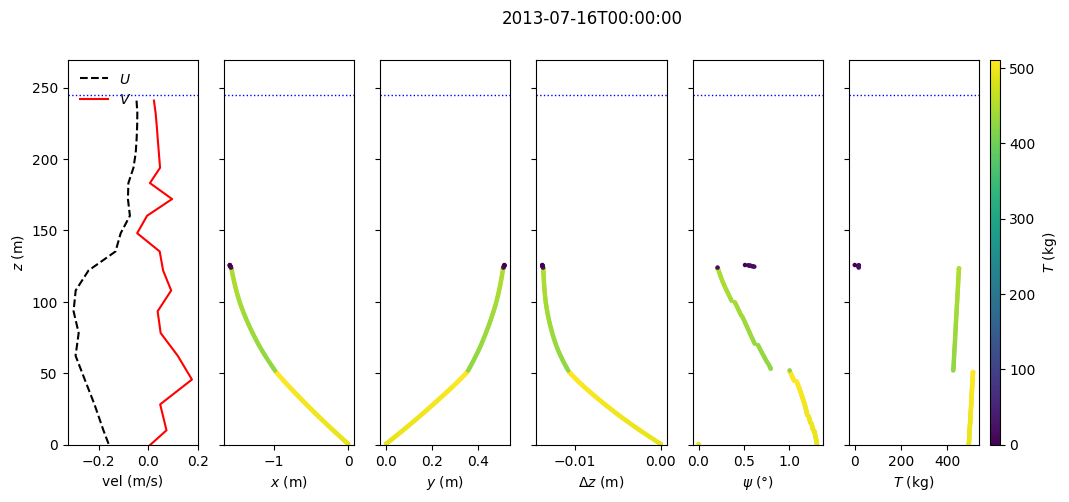

In [18]:
fig, ax = series.plot_instance(time_idx=15)
plt.show()

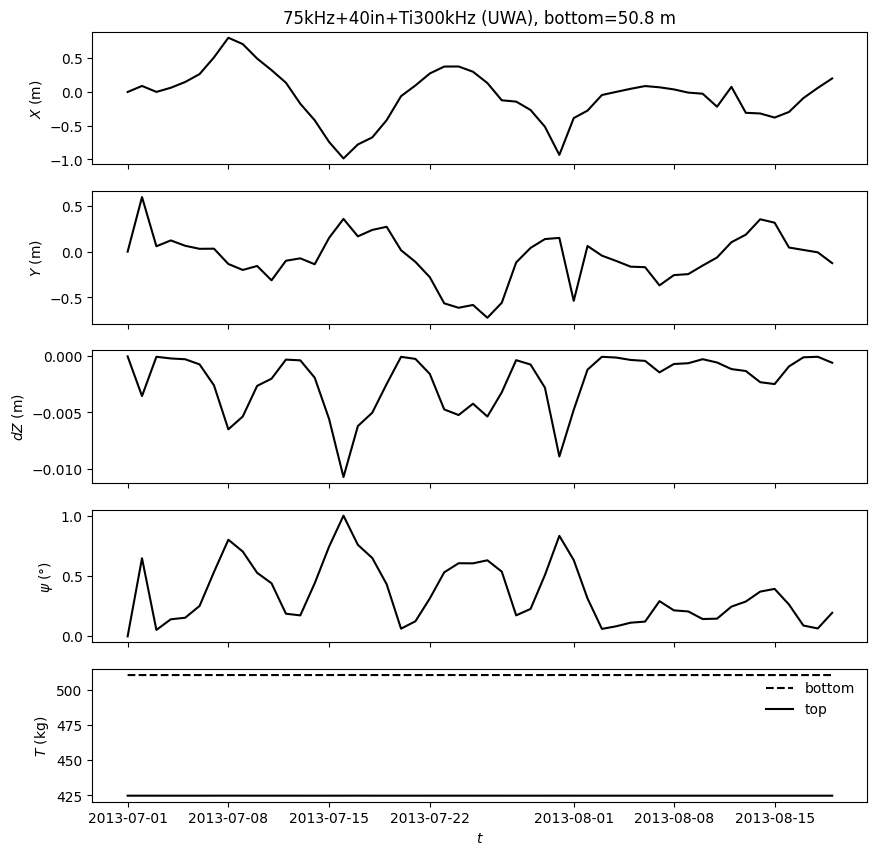

In [19]:
fig, ax = series.plot_simulated_item_series(item_id=7)
plt.show()

In [20]:
# Element summary (including clamp-ons and in-lines)
df_sim_series_summary = series.df_summary_series
df_sim_series_summary[
    (df_sim_series_summary.type != "rigging")
    & (df_sim_series_summary.type != "wires")
    & (df_sim_series_summary.type != "chains")
].head()

,type,name,serial,psi_mean,psi_std,psi_01,psi_99,psi_min,psi_max,dZ_mean,dZ_std,dZ_01,dZ_99,dZ_min,dZ_max
id,,,,,,,,,,,,,,,
0,anchors,3 Railway Wheels,None,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,miscs,Zn Anode (UWA),None,0.533285,0.335206,0.035155,1.267557,0.0,1.295048,-0.000248,0.000263,-0.001002,-0.000002,-0.001043,0.0
7,cms,75kHz+40in+Ti300kHz (UWA),None,0.362677,0.249108,0.026342,0.922905,0.0,1.005180,-0.002257,0.002481,-0.009859,-0.000017,-0.010758,0.0
8,cms,Sentinel,20089,0.362677,0.249108,0.026342,0.922905,0.0,1.005180,-0.002241,0.002464,-0.009806,-0.000017,-0.010683,0.0
9,cms,Longranger,16870,0.362677,0.249108,0.026342,0.922905,0.0,1.005180,-0.002273,0.002498,-0.009911,-0.000017,-0.010834,0.0
